## Análisis de datos - Clase 4

### Tratamiento de outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer

In [2]:
# Cargar el dataset de Titanic
df_titanic = sns.load_dataset("titanic")

# Seleccionar variables numéricas relevantes
df = df_titanic[['age', 'fare']].dropna()
df.head(10)

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
6,54.0,51.8625
7,2.0,21.0750
8,27.0,11.1333
9,14.0,30.0708
10,4.0,16.7000


In [3]:
df.describe()

,age,fare
count,714.000000,714.000000
mean,29.699118,34.694514
std,14.526497,52.918930
min,0.420000,0.000000
25%,20.125000,8.050000
50%,28.000000,15.741700
75%,38.000000,33.375000
max,80.000000,512.329200


### Detectamos outliers en base al rango intercuartil

Un dato se considera outlier si es < (Q1 - 1.5 * IQR)) o > (Q3 + 1.5 * IQR)

In [4]:
# Métodos estadísticos para detectar outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

IQR = Q3 - Q1
outliers_iqr = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
print(f"Outliers\nAge: <{Q1['age'] - 1.5 * IQR['age']:.02f} o >{Q3['age'] + 1.5 * IQR['age']:.02f}")
print(f"Fare: <{Q1['fare'] - 1.5 * IQR['fare']:.02f} o >{Q3['fare'] + 1.5 * IQR['fare']:.02f}")

Outliers
Age: <-6.69 o >64.81
Fare: <-29.94 o >71.36


### Estrategias de eliminación y tratamiento de outliers

#### 1. Eliminación de outliers

In [5]:
# Datos con outliers detectados
outliers_detected = df[outliers_iqr.any(axis=1)]
outliers_detected

,age,fare
27,19.0,263.0000
33,66.0,10.5000
34,28.0,82.1708
52,49.0,76.7292
54,65.0,61.9792
...,...,...
829,62.0,80.0000
835,39.0,83.1583
851,74.0,7.7750
856,45.0,164.8667


In [6]:
# 1. Eliminación de outliers
df_no_outliers = df[~outliers_iqr.any(axis=1)]
df_no_outliers.describe()

,age,fare
count,609.000000,609.000000
mean,28.275452,19.104857
std,13.416418,14.473114
min,0.420000,0.000000
25%,20.000000,7.925000
50%,28.000000,13.000000
75%,36.000000,26.250000
max,64.000000,71.283300


#### 2. Transformación logarítmica para reducir impacto de outliers

In [7]:
# 2. Transformación logarítmica para reducir impacto de outliers
df_transformed = df.copy()
df_transformed['fare'] = np.log1p(df_transformed['fare'])
df_transformed.describe()

,age,fare
count,714.000000,714.000000
mean,29.699118,3.042013
std,14.526497,0.952459
min,0.420000,0.000000
25%,20.125000,2.202765
50%,28.000000,2.817903
75%,38.000000,3.537310
max,80.000000,6.240917


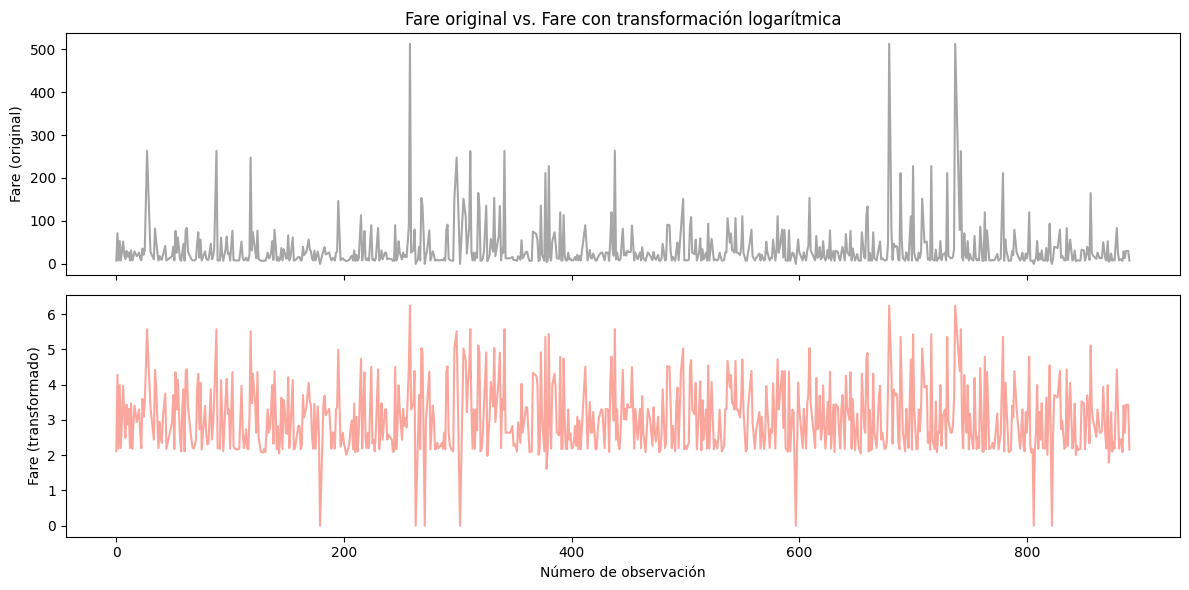

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# Primer gráfico: datos originales
axes[0].plot(df.index, df['fare'], alpha=0.7, color='gray')
axes[0].set_ylabel('Fare (original)')
axes[0].set_title('Fare original vs. Fare con transformación logarítmica')

# Segundo gráfico: datos imputados
axes[1].plot(df_transformed.index, df_transformed['fare'], alpha=0.7, color='salmon')
axes[1].set_ylabel('Fare (transformado)')
axes[1].set_xlabel('Número de observación')

plt.tight_layout()
plt.show()


#### 3. Imputación

#### 3.a) imputación por mediana

In [18]:
df_imputed = df.copy()
df_imputed.loc[outliers_iqr['fare'], 'fare'] = df['fare'].median()
df_imputed.describe()

,age,fare
count,714.000000,714.000000
mean,29.699118,18.813082
std,14.526497,13.748211
min,0.420000,0.000000
25%,20.125000,8.050000
50%,28.000000,15.741700
75%,38.000000,26.000000
max,80.000000,71.283300


In [10]:
# miro las observaciones que fueron imputadas
df_compara = pd.concat([df['fare'], df_imputed['fare']], axis=1)
df_compara.columns = ['original', 'imputado']
df_compara[df_compara['original']!=df_compara['imputado']]

,original,imputado
27,263.0000,15.7417
34,82.1708,15.7417
52,76.7292,15.7417
61,80.0000,15.7417
62,83.4750,15.7417
...,...,...
820,93.5000,15.7417
829,80.0000,15.7417
835,83.1583,15.7417
856,164.8667,15.7417


#### 3.b) Imputación con KNN

In [17]:
imputer = KNNImputer(n_neighbors=5)
df_nan = df.copy()

df_nan[outliers_iqr] = np.nan  # marca outliers como NaN

df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_nan),
                              columns=df.columns,
                              index=df_nan.index # sin esto, se pierde el índice original
                             )

df_knn_imputed.describe()

,age,fare
count,714.000000,714.000000
mean,29.168305,19.606931
std,13.683456,13.939995
min,0.420000,0.000000
25%,20.125000,8.050000
50%,28.000000,14.454200
75%,38.000000,26.287500
max,64.000000,71.283300


In [12]:
# comparo las observaciones originales con las imputaciones
df_compara_knn = pd.concat([df, df_nan, df_knn_imputed], axis=1)

df_compara_knn.columns = ['age_original', 'fare_original', 'age_nan', 'fare_nan', 'age_imputado', 'fare_imputado']

df_compara_knn.head(30) # se observan imputaciones de Fare

,age_original,fare_original,age_nan,fare_nan,age_imputado,fare_imputado
0,22.0,7.2500,22.0,7.2500,22.0,7.25000
1,38.0,71.2833,38.0,71.2833,38.0,71.28330
2,26.0,7.9250,26.0,7.9250,26.0,7.92500
3,35.0,53.1000,35.0,53.1000,35.0,53.10000
4,35.0,8.0500,35.0,8.0500,35.0,8.05000
6,54.0,51.8625,54.0,51.8625,54.0,51.86250
7,2.0,21.0750,2.0,21.0750,2.0,21.07500
8,27.0,11.1333,27.0,11.1333,27.0,11.13330
9,14.0,30.0708,14.0,30.0708,14.0,30.07080
10,4.0,16.7000,4.0,16.7000,4.0,16.70000


In [13]:
df_compara_knn.sort_values('age_original')  # para ver las imputaciones de Age

,age_original,fare_original,age_nan,fare_nan,age_imputado,fare_imputado
803,0.42,8.5167,0.42,8.5167,0.42,8.5167
755,0.67,14.5000,0.67,14.5000,0.67,14.5000
644,0.75,19.2583,0.75,19.2583,0.75,19.2583
469,0.75,19.2583,0.75,19.2583,0.75,19.2583
78,0.83,29.0000,0.83,29.0000,0.83,29.0000
...,...,...,...,...,...,...
116,70.50,7.7500,NaN,7.7500,32.20,7.7500
493,71.00,49.5042,NaN,49.5042,36.80,49.5042
96,71.00,34.6542,NaN,34.6542,28.20,34.6542
851,74.00,7.7750,NaN,7.7750,24.60,7.7750


#### 4. Segmentación

In [19]:
# Segmentación: Crea una categoría de "outlier" en 'fare'
df_segmented = df.copy()
df_segmented['fare_outlier'] = outliers_iqr['fare'].apply(lambda x: 'Outlier' if x else 'Normal')
df_segmented.sort_values('fare_outlier')

,age,fare,fare_outlier
0,22.0,7.2500,Normal
574,16.0,8.0500,Normal
575,19.0,14.5000,Normal
576,34.0,13.0000,Normal
577,39.0,55.9000,Normal
...,...,...,...
537,30.0,106.4250,Outlier
124,54.0,77.2875,Outlier
318,31.0,164.8667,Outlier
139,24.0,79.2000,Outlier
